# Setting Up

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

data_dir = 'dataset'

train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.MNIST(data_dir, train=False, download=True)

train_transform = transforms.Compose([
transforms.ToTensor(),
])

test_transform = transforms.Compose([
transforms.ToTensor(),
])

train_dataset.transform = train_transform
test_dataset.transform = test_transform

m=len(train_dataset)

train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])
batch_size=64

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

sample_x, sample_y = next(iter(train_loader))

100%|██████████| 9912422/9912422 [00:00<00:00, 400517424.44it/s]

Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 26576501.50it/s]


Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 156210137.03it/s]


Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 2263070.65it/s]


Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



In [2]:
def show_image(data, idx=None):
  if idx:
    plt.imshow(data[idx].transpose(0, 2).detach().numpy())
  else:
    plt.imshow(data.transpose(0, 2).detach().numpy())

# Encoder

In [3]:
class Encoder(nn.Module):
  def __init__(self, kernel=(3, 3), stride=1):
    super().__init__()
    self.kernel_size = kernel
    self.stride = stride

    self.conv_stack = nn.Sequential(
        nn.Conv2d(1, 3, self.kernel_size, stride=self.stride),
        nn.ReLU(),

        nn.Conv2d(3, 6, self.kernel_size, stride=self.stride),
        nn.ReLU(),


        nn.BatchNorm2d(6),


        nn.Conv2d(6, 12, self.kernel_size, stride=self.stride),
        nn.ReLU(),

        nn.Conv2d(12, 24, self.kernel_size, stride=self.stride),
        nn.ReLU(),


        nn.BatchNorm2d(24),

        nn.Conv2d(24, 48, self.kernel_size, stride=self.stride),
        nn.ReLU(),

        nn.Conv2d(48, 96, self.kernel_size, stride=self.stride),
        nn.ReLU()
    )


    self.linear_stack = nn.Sequential(
        nn.Linear(1536, 768),
        nn.ReLU(),
        nn.Linear(768, 256),
        nn.ReLU(),
    )

  def forward(self, x):
    x = self.conv_stack(x)
    x = self.linear_stack(x.flatten(1))
    return x

In [4]:
encoder = Encoder((5,5), 1)
x = encoder(sample_x)
print(x.shape)

torch.Size([64, 256])


# Decoder

In [5]:
class Decoder(nn.Module):
  def __init__(self, kernel=(3,3), stride=1):
    super().__init__()

    self.kernel = kernel
    self.stride = stride

    self.linear_stack = nn.Sequential(
        nn.Linear(256, 768),
        nn.ReLU(),
        nn.Linear(768, 1536),
        nn.ReLU()
    )

    self.unflatten = nn.Unflatten(dim=1, unflattened_size=(96, 4, 4))

    self.conv_stack = nn.Sequential(
      nn.ConvTranspose2d(96, 48, self.kernel, self.stride),
      nn.ReLU(),

      nn.ConvTranspose2d(48, 24, self.kernel, self.stride),
      nn.ReLU(),

      nn.BatchNorm2d(24),

      nn.ConvTranspose2d(24, 12, self.kernel, self.stride),
      nn.ReLU(),

      nn.ConvTranspose2d(12, 6, self.kernel, self.stride),
      nn.ReLU(),


      nn.BatchNorm2d(6),


      nn.ConvTranspose2d(6, 3, self.kernel, self.stride),
      nn.ReLU(),

      nn.ConvTranspose2d(3, 1, self.kernel, self.stride),
      nn.ReLU(),

    )

  def forward(self, x):
    x = self.linear_stack(x)
    x = self.unflatten(x)
    x = self.conv_stack(x)
    return x

torch.Size([64, 1, 28, 28])


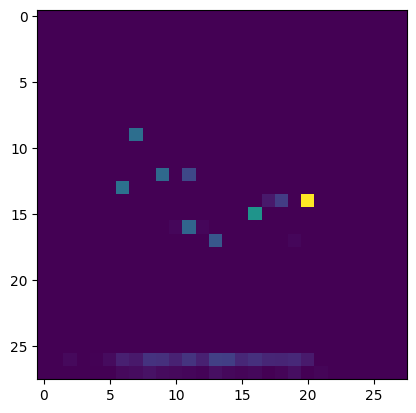

In [6]:
decoder = Decoder((5, 5), 1)
y = decoder(x)
print(y.shape)
show_image(y, 1)

# Hyperparameter search

In [7]:
def train(encoder, decoder, optim_func, loss_func, train_dataloader):
  encoder.train()
  decoder.train()

  loss_arr = []

  for idx, (X, y) in enumerate(train_dataloader):
    encoder_out = encoder(X)
    decoder_out = decoder(encoder_out)

    loss = loss_func(decoder_out, X)
    optim_func.zero_grad()

    loss.backward()
    optim_func.step()

    loss_arr.append(loss.item())
  return loss_arr


In [8]:
encoder = Encoder((5,5), 1)
decoder = Decoder((5, 5), 1)

loss_func = nn.L1Loss()
optim_func = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=0.0001)

epochs = 5

for epoch in range(epochs):
  print(f'Epoch: {epoch}')
  loss_arr = train(encoder, decoder, optim_func, loss_func, train_loader)
  print(f'AVG loss: {sum(loss_arr)/len(loss_arr)}')

Epoch: 0
AVG loss: 0.08916282919545969
Epoch: 1
AVG loss: 0.05495142725110054
Epoch: 2
AVG loss: 0.04444561256965002
Epoch: 3
AVG loss: 0.040185232256849605
Epoch: 4
AVG loss: 0.036945535416404406


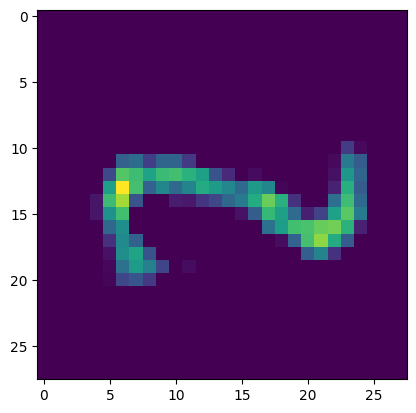

In [9]:
x = encoder(sample_x)
x = decoder(x)

show_image(x, 1)